In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Utilitiy functions

In [2]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def stc_pass(inputs, layer, n):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", 100, 100, tf.nn.sigmoid)
        inputs = tf.reshape(Bernoulli(probs=z,dtype=tf.float32).sample(n), [n*n*batch_size,100])
    z = add_layer(inputs, "why", "bhy", 100, 392, tf.nn.sigmoid)
    z = tf.reduce_mean(tf.reshape(z,[n,n*batch_size,392]), 0) if layer==1 else z
    z = prob(z, tf.tile(y_,[n,1]))
    z_expect = tf.reduce_mean(tf.reshape(z, [n,batch_size,392]), 0)
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-z_expect-eps, [n,1])), 1, keep_dims=True), z_expect

def fg_cov(f, g, w, n):
    f, g = [tf.reshape(z, [n,batch_size,100]) for z in [f,g]]
    for i in range(n):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        mf, mg = [df, dg] if i==0 else [mf+df, mg+dg]
        vg = tf.square(dg) if i==0 else vg+tf.square(dg)
        cov = df*dg if i==0 else cov+df*dg
    return mf/n, mg/n, (cov-mf*mg/n)/(n-1), (vg-tf.square(mg)/n)/(n-1)

def gd_stats(p, s, f, g, mg, dh, w):
    mdf, mdg = [tf.concat(tf.gradients(tf.reduce_mean(z,0), w), 0) for z in [f, g]]
    mgd = tf.concat([dh[0][0], dh[1][0]], 0)
    
    f, g, s = [tf.reshape(z, [ns, batch_size, 100]) for z in [f, g, s]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w), 0) for z in [f[i], g[i]]]
        vf = tf.square(df-mdf) if i==0 else vf+tf.square(df-mdf)
        vg = tf.square(dg-mdg) if i==0 else vg+tf.square(dg-mdg)        
        cov = (df-mdf)*(dg-mdg) if i==0 else cov+(df-mdf)*(dg-mdg)
        gd = tf.concat(tf.gradients(tf.reduce_mean(f[i]-g[i]+mg, 0), w), 0)
        vgd = tf.square(gd-mgd) if i==0 else vgd+tf.square(gd-mgd)    
    vf, vg, cov, vgd = [tf.reduce_sum(z)/(ns-1) for z in [vf, vg, cov, vgd]]
    return vf+vg-2*cov, vgd

### Parameters

In [3]:
batch_size = 4
lr = 1e-3
eps = 1e-7
alpha = 0.9
linear = True

### Graph

In [4]:
def get_weights(wn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        return tf.get_variable(wn)

def add_layer(inputs, wn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [out_dim, in_dim+1], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
    inputs = tf.concat([inputs, tf.ones([tf.shape(inputs)[0],1])], 1)
    ww = tf.transpose(w)
    return tf.matmul(inputs, ww) if af is None else af(tf.matmul(inputs, ww))

prob = lambda p, s: tf.pow(p+eps,s)*tf.pow(1-p+eps,1-s)
log_prob = lambda p, s: tf.log(prob(p, s))


ns = tf.placeholder(tf.int32)
x = tf.placeholder(tf.float32, [None, 392])
h = add_layer(x, "wxh", 392, 100, tf.nn.sigmoid)
sh = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), [-1,100]))
h2 = add_layer(sh, "whh", 100, 100, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns), [-1,100]))
y = add_layer(sh2, "why", 100, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns**2, -1, 392]), 0)
y_ = tf.placeholder(tf.float32, [None, 392])

nll = tf.reduce_mean(tf.reduce_sum(-log_prob(y_expect, y_), 1))
ls2 = tf.reduce_sum(tf.tile(-(y_-y_expect)/(y_expect*(1-y_expect)+eps),[ns**2,1])*y, 1, keep_dims=True)
ls  = tf.reduce_mean(tf.reshape(ls2, [ns,-1,1]), 0)
_h, _h2 = [tf.tile(z, [ns, 1]) for z in [h, h2]]

In [5]:
opt = tf.train.GradientDescentOptimizer(lr)
dy = opt.compute_gradients(nll, get_weights("why"))    
dh = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls2)*log_prob(_h2, sh2), 0), 
                           get_weights("whh"))        
dx = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls)*log_prob(_h, sh), 0),
                           get_weights("wxh"))
gd = [list(i) for i in dy]+[list(i) for i in dh]+[list(i) for i in dx]
for i in range(3):
    gd[i][0] = tf.check_numerics(gd[i][0], "gd!")
train_step = opt.apply_gradients(gd)

In [7]:
_wxh = tf.placeholder(tf.float32, [100,393])
_whh = tf.placeholder(tf.float32, [100,101])
_why = tf.placeholder(tf.float32, [392,101])
_dx = tf.placeholder(tf.float32, [100,393])
_dh = tf.placeholder(tf.float32, [100,101])

lh = tf.nn.sigmoid(tf.matmul(tf.concat([x,tf.ones([tf.shape(x)[0],1])],1), tf.transpose(_wxh)))
lh2 = tf.nn.sigmoid(tf.matmul(tf.concat([sh,tf.ones([tf.shape(sh)[0],1])],1), tf.transpose(_whh)))
ly  = tf.nn.sigmoid(tf.matmul(tf.concat([sh2,tf.ones([tf.shape(sh2)[0],1])],1), tf.transpose(_why)))
ly_expect = tf.reduce_mean(tf.reshape(ly, [ns**2, -1, 392]), 0)

lnll = tf.reduce_mean(tf.reduce_sum(-log_prob(ly_expect, y_), 1))
lls2 = tf.reduce_sum(tf.tile(-(y_-ly_expect)/(ly_expect*(1-ly_expect)+eps),[ns**2,1])*ly, 1, keep_dims=True)
lls = tf.reduce_mean(tf.reshape(lls2, [ns,-1,1]), 0)
_lh, _lh2 = [tf.tile(z, [ns, 1]) for z in [lh, lh2]]

ldy = tf.gradients(lnll,_why)[0]
ldh = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls2)*log_prob(_lh2, sh2), 0), _whh)[0]
ldx = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls)*log_prob(_lh, sh), 0),_wxh)[0]

lgd = [list(i) for i in dy] + [list(i) for i in dh] + [list(i) for i in dx]
lgd[2][0] = lgd[2][0] - ldx + _dx
lgd[1][0] = lgd[1][0] - ldh + _dh

ltrain_step = opt.apply_gradients(lgd)

### NGD DPR1

In [91]:
ts  = tf.placeholder(tf.float32)

lh = tf.nn.sigmoid(tf.matmul(tf.concat([x,tf.ones([tf.shape(x)[0],1])],1), tf.transpose(_wxh)))
lh2 = tf.nn.sigmoid(tf.matmul(tf.concat([sh,tf.ones([tf.shape(sh)[0],1])],1), tf.transpose(_whh)))
ly  = tf.nn.sigmoid(tf.matmul(tf.concat([sh2,tf.ones([tf.shape(sh2)[0],1])],1), tf.transpose(_why)))
ly_expect = tf.reduce_mean(tf.reshape(ly, [ns**2, -1, 392]), 0)

lls2 = tf.reduce_sum(tf.tile(-(y_-ly_expect)/(ly_expect*(1-ly_expect)+eps),[ns**2,1])*ly, 1, keep_dims=True)
lls = tf.reduce_mean(tf.reshape(lls2, [ns,-1,1]), 0)
_lh, _lh2 = [tf.tile(z, [ns, 1]) for z in [lh, lh2]]

ldh = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls2)*log_prob(_lh2, sh2), 0), _whh)[0]
ldx = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls)*log_prob(_lh, sh), 0),_wxh)[0]

beta = .999
alpha = .9

djx = tf.placeholder(tf.float32,[3,100,393])
djh = tf.placeholder(tf.float32,[3,100,101])
djy = tf.placeholder(tf.float32,[3,392,101])

nlgd = [list(i) for i in dy] + [list(i) for i in dh] + [list(i) for i in dx]
layer = [[2, dx[0][0]-ldx+_dx, djx, 392], [1, dh[0][0]-ldh+_dh, djh, 100], [0, dy[0][0], djy, 100]]

for z in layer:
    J = z[1]
    dJ = beta*z[2][0]+(1-beta)*tf.square(J)+eps
    rJ = beta*z[2][1]+(1-beta)*J*tf.transpose([J[:,-1]])
    u = tf.concat([rJ[:,0:-1]/dJ[:,0:-1], -1*tf.ones([tf.shape(rJ)[0],1])],1)
    rho = tf.transpose([1/((1-z[3])*dJ[:,-1])])    
    
    gg = alpha*z[2][2] + (1-alpha)*z[1]
    ng = tf.concat([gg[:,0:-1]/dJ[:,0:-1], tf.zeros([tf.shape(gg)[0],1])],1)
    ng += tf.reduce_sum(u*gg,1,keep_dims=True)*u*rho
    ng *= (1-tf.pow(beta,ts+1))/(1-tf.pow(alpha,ts+1))
    nlgd[z[0]][0] = tf.check_numerics(ng, "!!!")
    
    if z[0]==2:
        xdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
    elif z[0]==1:
        hdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)        
    else:
        ydj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
        
nltrain_step = opt.apply_gradients(nlgd)

In [92]:
_layer = [[2, dx[0][0], djx], [1, dh[0][0], djh]]
for z in _layer:
    _J = z[1]
    _dJ = beta*z[2][0]+(1-beta)*tf.square(_J)+eps
    _rJ = beta*z[2][1]+(1-beta)*_J*tf.transpose([_J[:,-1]])
    _gg = alpha*z[2][2] + (1-alpha)*z[1]
    
    if z[0]==2:
        _xdj = tf.concat([tf.concat([[_dJ],[_rJ]],0),[_gg]],0)
    else:
        _hdj = tf.concat([tf.concat([[_dJ],[_rJ]],0),[_gg]],0)

### Train

In [93]:
steps = 50000

with tf.Session() as sess:
    loss_rec = np.empty((1000, steps/1000))
    cdx = wwx = np.zeros([100,393])
    cdh = wwh = np.zeros([100,101])
    
    aacX = np.zeros([100,393,1])
    aacH = np.zeros([100,101,1])
    aacY = np.zeros([392,101,1])
    
    ddjx = np.zeros([3,100,393])
    ddjh = np.zeros([3,100,101])
    ddjy = np.zeros([3,392,101])    
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(steps):
        if i%4==0:    
            batch_   = data.next_batch(4, shuffle=True)[0]
            batch_xs = batch_[:, 0:392]
            batch_ys = batch_[:, 392:784]
            res = sess.run([gd[2], gd[1], gd[0][1] _xdj, _hdj],
                           {x: batch_xs, y_: batch_ys, ns: 4,
                            _dx: cdx, _dh: cdh, _wxh: wwx, _whh: wwh, _why: wwy, ts:i,
                            djx:ddjx, djh:ddjh, djy:ddjy
                           })
            cdx,cdh = res[0][0],res[1][0]
            wwx,wwh,wwy = res[0][1],res[1][1],res[2]
            ddjx,ddjh = res[3],res[4]
            
        batch_   = data.next_batch(2, shuffle=True)[0]
        batch_xs = batch_[:, 0:392]
        batch_ys = batch_[:, 392:784]
        
        res = sess.run([nll, 
#                        train_step],
#                        mptrain_step],
#                        ltrain_step],
#                        nftrain_step, xdj, hdj, ydj, acX,acH,acY],
#                        ntrain_step, xdj, hdj, ydj],
                        nltrain_step, xdj, hdj, ydj],
                        {x: batch_xs, y_: batch_ys, ns: 2,
                        _dx: cdx, _dh: cdh, _wxh: wwx, _whh: wwh, _why: wwy, ts:i,
                         djx:ddjx, djh:ddjh, djy:ddjy
                       })
#        cdx,cdh = res[2],res[3]
#        wwx,wwh,wwy = res[5],res[6],res[7]            
#        aacX,aacH,aacY = res[5],res[6],res[7]

        ddjx,ddjh,ddjy = res[2],res[3],res[4]
            
        loss_rec[i%1000, i/1000] = res[0]
        if (i+1)%1000==0:
            print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0), 

nsgd3 = loss_rec
#np.save("dn_20_4.npy", dn_20_4)

1 225.254691429 2 124.770983047 3 116.988815437 4 110.317568516 5 109.357285065 6 107.832994453 7 104.960482742 8 103.705100246 9 102.307760189 10 101.655282925 11 101.5728297 12 101.544287056 13 100.17272366 14 99.766395504 15 100.113553829 16 100.11707626 17 99.1629824142 18 97.5026843433 19 99.6103045692 20 98.6601902084 21 99.082146492 22 98.2370067177 23 97.7527176437 24 96.7252200775 25 95.0209106674 26 97.1948443718 27 97.2832447014 28 95.6437379723 29 95.8304495697 30 94.2512701111 31 95.2264854736 32 95.5284529953 33 96.6347760124 34 95.3685139656 35 94.764275444 36 94.2799138031 37 94.8070655651 38 95.5464148521 39 94.9538411179 40 94.4358834763 41 95.1500784912

KeyboardInterrupt: 

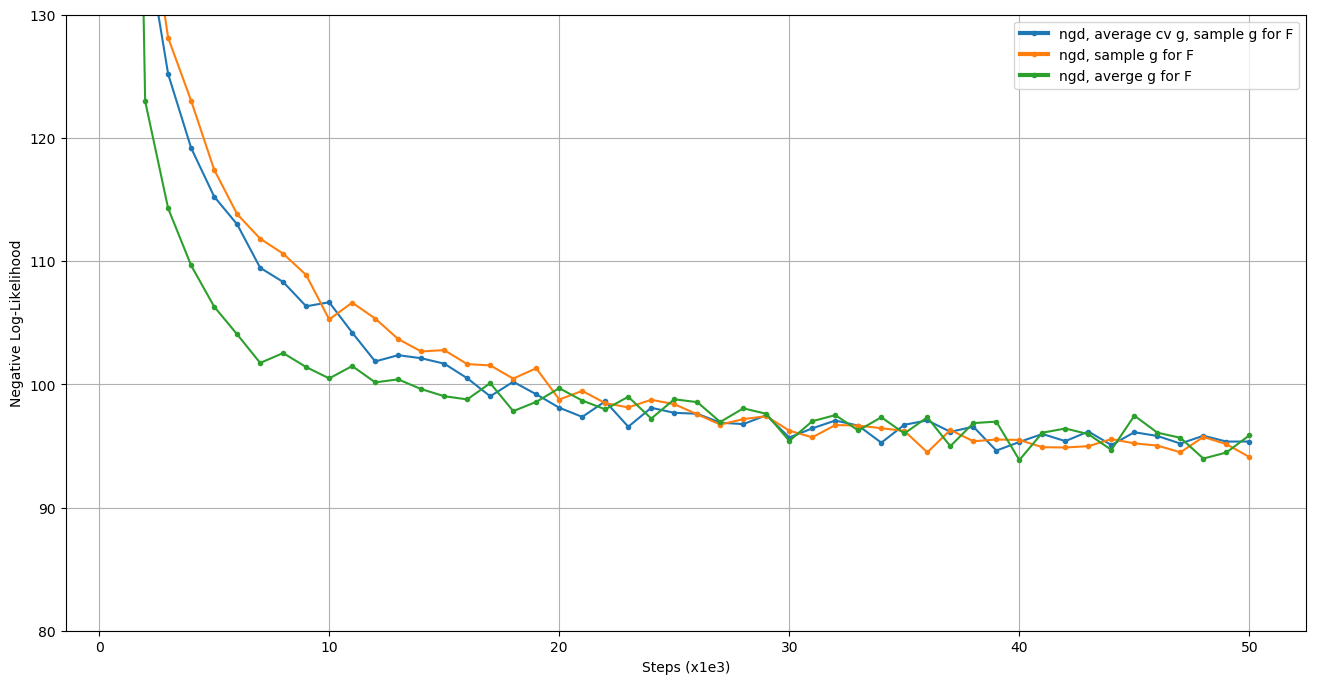

In [25]:
#saver = tf.train.Saver()

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.ylim(80,130)

#plot_banded_error(sgd, "sgd")
#plot_banded_error(sgdmp, "sgdmp")
#plot_banded_error(adm, "adam")
#plot_banded_error(adm2, "adam svrg")
#plot_banded_error(admmp, "adammp")
plot_banded_error(nsgd, "ngd, average cv g, sample g for F")
plot_banded_error(nsgd2, "ngd, sample g for F")
plot_banded_error(nsgd3, "ngd, averge g for F")





fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('ns.png')

In [ ]:
def det_pass(inputs, layer, n, _expect, w1, w2):
    inputs = tf.concat([inputs, tf.ones([tf.shape(inputs)[0],1])], 1)
    if layer==1:
        inputs = tf.nn.sigmoid(tf.matmul(inputs,tf.transpose(w1)))
        inputs = tf.concat([inputs, tf.ones([tf.shape(inputs)[0],1])], 1)
    z = prob(tf.nn.sigmoid(tf.matmul(inputs,tf.transpose(w2))), tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-_expect-eps,[n,1])), 1, keep_dims=True)

def muProp(p, s, layer, _expect, linear, w1, w2, w3):
    fh = det_pass(p, layer, ns**(layer-1), prob(_expect, y_), w2, w3)
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    
    w = w1 if layer==1 else w2
    dg, dmg = [tf.gradients(tf.reduce_mean(z, 0), w)[0]
               for z in [tf.stop_gradient(g)*log_prob(p, s), mg]]
    return dg-dmg if linear else dmg/(dg+eps)


cvh = muProp(h2, sh2, 2, y_expect, linear,
             get_weights("wxh"), get_weights("whh"), get_weights("why"))
cvx = muProp(h, sh, 1, y_expect, linear,
             get_weights("wxh"), get_weights("whh"), get_weights("why"))

mpgd = [list(i) for i in dy]+[list(i) for i in dh]+[list(i) for i in dx]
mpgd[1][0] -= cvh
mpgd[2][0] -= cvx
mptrain_step = opt.apply_gradients(mpgd)

In [125]:
accuX = tf.placeholder(tf.float32,[100,393,None])
accuH = tf.placeholder(tf.float32,[100,101,None])
accuY = tf.placeholder(tf.float32,[392,101,None])

nfgd = [list(i) for i in dy] + [list(i) for i in dh] + [list(i) for i in dx]
layer = [[dx[0][0], 2, _dx, accuX, [100,393], tf.stop_gradient(ls)*log_prob(_h,sh),    "wxh"],
         [dh[0][0], 1, _dh, accuH, [100,101], tf.stop_gradient(ls2)*log_prob(_h2,sh2), "whh"],
         [dy[0][0], 0, _dy, accuY, [392,101], -log_prob(y,tf.tile(y_,[ns**2,1])),      "why"]]

for z in layer:
    n = 2 if z[1]==2 else 4
    jz = tf.reshape(z[5],[n,tf.shape(x)[0],-1])
    for i in range(n):
#        J = alpha*z[2] + (1-alpha)*tf.gradients(tf.reduce_mean(jz[i], get_weights(z[6]))[0]
        J = tf.gradients(tf.reduce_mean(jz[i],0), get_weights(z[6]))[0]
        gg = J if i==0 else tf.concat([gg, J], 1)
    gg = tf.reshape(gg,[z[4][0], -1, z[4][1]])

    XX = tf.concat([np.sqrt(beta)*z[3], np.sqrt(1-beta)*tf.transpose(gg,perm=[0,2,1])], 2)
    FIM = tf.matmul(tf.transpose(XX, perm=[0,2,1]),XX)
    
    idx = tf.shape(XX)[2]
    iFIM = tf.matrix_inverse(FIM+tf.tile(tf.expand_dims(tf.diag(tf.ones([idx])*.01),0),[z[4][0],1,1]))
    ii = tf.expand_dims(tf.concat([tf.zeros([z[4][0],idx-n]), tf.ones([z[4][0],n])/n],1),-1)
    ng = tf.matmul(tf.matmul(XX,iFIM), ii)

    nfgd[z[1]][0] = tf.check_numerics(tf.squeeze(ng),"!!!")
    
    XX = tf.cond(tf.greater_equal(idx,30), lambda: XX[:,:,n:], lambda: XX)
#    sx, _, vx = tf.cond(tf.greater_equal(idx,10), lambda: tf.svd(FIM), lambda: [XX,XX,XX])
 #   XX = tf.cond(tf.greater_equal(idx,10), 
  #               lambda: tf.matmul(XX, vx[:,:,0:5])/tf.expand_dims(tf.sqrt(sx[:,0:5])+eps, 1),
   #              lambda: XX)
    
    gg = tf.reduce_mean(gg,1)
    
    if z[1]==2:
        acX,xdj = XX,gg
    elif z[1]==1:
        acH,hdj = XX,gg        
    else:
        acY,ydj = XX,gg
        
nftrain_step = opt.apply_gradients(nfgd)

In [8]:
beta = .999
alpha = .9

djx = tf.placeholder(tf.float32,[3,100,393])
djh = tf.placeholder(tf.float32,[3,100,101])
djy = tf.placeholder(tf.float32,[3,392,101])

ngd = [list(i) for i in dy] + [list(i) for i in dh] + [list(i) for i in dx]
layer = [[tf.stop_gradient(ls)*log_prob(_h, sh),    "wxh",392, dx[0][0],2,djx],
         [tf.stop_gradient(ls2)*log_prob(_h2, sh2), "whh",100, dh[0][0],1,djh],
         [-log_prob(y, tf.tile(y_,[ns**2,1])),      "why",100, dy[0][0],0,djy]]         

for z in layer:
    n = 2 if z[4]==2 else 4
        
    jz = tf.reshape(z[0],[n,tf.shape(x)[0],-1])
    for i in range(n):
        J = tf.gradients(tf.reduce_mean(jz[i],0), get_weights(z[1]))[0]        
        dJ = tf.square(J) if i==0 else dJ+tf.square(J)
        rJ = J*tf.transpose([J[:,-1]]) if i==0 else rJ+J*tf.transpose([J[:,-1]])
        
    dJ = beta*z[5][0]+(1-beta)*dJ/n + eps
    rJ = beta*z[5][1]+(1-beta)*rJ/n
    u = tf.concat([rJ[:,0:-1]/dJ[:,0:-1], -1*tf.ones([tf.shape(rJ)[0],1])],1)
    rho = tf.transpose([1/((1-z[2])*dJ[:,-1])])    
    
    gg = alpha*z[5][2] + (1-alpha)*z[3]
    ng = tf.concat([gg[:,0:-1]/dJ[:,0:-1], tf.zeros([tf.shape(gg)[0],1])],1)
    ng += tf.reduce_sum(u*gg,1,keep_dims=True)*u*rho
    ng *= (1-tf.pow(beta,ts+1))/(1-tf.pow(alpha,ts+1))

    ngd[z[4]][0] = tf.check_numerics(ng, "!!!")
    
    if z[4]==2:
        xdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
    elif z[4]==1:
        hdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)        
    else:
        ydj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)

ntrain_step = opt.apply_gradients(ngd)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in batch_xs]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in batch_ys]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), 1, 1), 0)
#dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[4]]], 1)
#p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
#ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
#ax[1].grid(False)
plt.show()

### Gradient estimators

In [ ]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear, cf, sta, nn):
    func = {
        0: lambda p, s, layer, w, cf, nn: [tf.zeros([ns**layer*batch_size,1]), tf.zeros([1])],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    g2, mg2 = func.get(md)(h2, sh2, 2, get_weights("whh", "bhh"), cf, nn)
    g, mg = func.get(md)(h, sh, 1, get_weights("wxh", "bxh"), cf, nn)
    f, f2 = ls, ls2
    m = g2
    v = tf.constant(0.)
    tr = None
    
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:
        c2 = cv_coef(h2, nn, 2, get_weights("whh", "bhh")) if cf else tf.ones([batch_size*ns,1])        
        c = cv_coef(h, nn, 1, get_weights("wxh", "bxh")) if cf else tf.ones([batch_size,1])   
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-tf.tile(c2,[ns,1])*g2)*log_prob(_h2, sh2), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c2)*mg2, 0), get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-tf.tile(c,[ns,1])*g)*log_prob(_h, sh), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c)*mg, 0), get_weights("wxh", "bxh"))
    else:
        dh2f, dh2g, dh2mg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("whh", "bhh"))
                             for z in [tf.stop_gradient(f2)*log_prob(_h2, sh2),
                                       tf.stop_gradient(g2)*log_prob(_h2, sh2), mg2]]
        dhf, dhg, dhmg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("wxh", "bxh"))
                          for z in [tf.stop_gradient(f)*log_prob(_h, sh),
                                    tf.stop_gradient(g)*log_prob(_h, sh), mg]]
        if cf:
            b2 = bias_cor(f2, g2, _h2, sh2, nn, 2, get_weights("whh", "bhh"), nh) 
            b = bias_cor(f, g, _h, sh, nn, 1, get_weights("wxh", "bxh"), 392)
        else:
            b2 = [tf.zeros([nh,nh]), tf.zeros([1,nh])]
            b = [tf.zeros([392,nh]), tf.zeros([1,nh])]
        
        dh2, dh = [list(z) for z in dh2f], [list(z) for z in dhf]
        for j in range(2):
            dh2[j][0] = (dh2[j][0]/(dh2g[j][0]+eps)-b2[j])*dh2mg[j][0]
            dh[j][0] = (dh[j][0]/(dhg[j][0]+eps)-b[j])*dhmg[j][0]

    gd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]

    train_step = opt.apply_gradients(gd if tr is None else gd+tr)
    return train_step, y_expect, nll, m, v

def muProp(p, s, layer, w, cf, nn):
    fh = det_pass(p, layer, ns**(layer-1), prob(y_expect, y_))
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    return g, mg

def cv_coef(p, nn, layer, w):
    p = tf.reshape(p, [ns**(layer-1), batch_size, nh])
    for i in range(ns**(layer-1)):
        pp = p[i]
        ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=pp, dtype=tf.float32).sample(nn), 
                                         [nn*batch_size, nh]))
        sls, sls_expect = stc_pass(ss, layer, nn)
        fh = det_pass(pp, layer, 1, sls_expect)
        dfh = tf.gradients(fh, pp)[0]
        _fh, _dfh, _p = [tf.tile(z, [nn,1]) for z in [fh, dfh, pp]]
        f = tf.stop_gradient(sls)*log_prob(_p, ss)
        g = tf.stop_gradient(_fh+tf.reduce_sum(_dfh*(ss-_p), 1, keep_dims=True))*log_prob(_p, ss)
        _, _, cov, vg = fg_cov(f, g, w, nn)
        t = tf.tile([[tf.reduce_sum(cov)/(tf.reduce_sum(vg)+eps)]],[batch_size,1])
        coef = t if i==0 else tf.concat([coef, t], 0)
    return coef

def bias_cor(f, g, p, s, nn, layer, w, dim):
    ff, gg = [tf.stop_gradient(z)*log_prob(s, p) for z in [f,g]]
    _f, _g = [tf.reshape(z,[ns,ns**(layer-1)*batch_size,nh]) for z in [ff,gg]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(z[i], w), 0) for z in [_f, _g]]
        mfg, mg = [df/(dg+eps), dg] if i==0 else [mfg+df/(dg+eps), mg+dg]
        sfgg = df if i==0 else sfgg+df
    mg /= ns
    sfgg = (sfgg-mg*mfg)/(ns-1)
    b = sfgg/(mg+eps)
    return b[0:dim], b[dim]

def DARN(p, s, layer, w, cf, nn):
    # only work for one layer
    if layer==1:
        return muProp(p, s, layer, w, cf, nn)
    dh = tf.gradients(ls2, s)[0] 
    g = ls2 + dh*(.5-s)
    return g, tf.zeros([1])

def baseline(p, s, layer, w, cf, nn):
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b)
    return g, tf.zeros([1])

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [114]:
_wxh = tf.placeholder(tf.float32, [100,393])
_whh = tf.placeholder(tf.float32, [100,101])
_why = tf.placeholder(tf.float32, [392,101])
_dx = tf.placeholder(tf.float32, [100,393])
_dh = tf.placeholder(tf.float32, [100,101])
_dy = tf.placeholder(tf.float32, [392,101])

wxh = get_weights("wxh")
whh = get_weights("whh")
why = get_weights("why")
ts  = tf.placeholder(tf.float32)

lh = tf.nn.sigmoid(tf.matmul(tf.concat([x,tf.ones([tf.shape(x)[0],1])],1), tf.transpose(_wxh)))
lh2 = tf.nn.sigmoid(tf.matmul(tf.concat([sh,tf.ones([tf.shape(sh)[0],1])],1), tf.transpose(_whh)))
ly  = tf.nn.sigmoid(tf.matmul(tf.concat([sh2,tf.ones([tf.shape(sh2)[0],1])],1), tf.transpose(_why)))
ly_expect = tf.reduce_mean(tf.reshape(ly, [ns**2, -1, 392]), 0)

lnll = tf.reduce_mean(tf.reduce_sum(-log_prob(ly_expect, y_), 1))
lls2 = tf.reduce_sum(prob(ly, tf.tile(y_,[ns**2,1]))/
                     tf.stop_gradient(tf.tile(-prob(ly_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
lls = tf.reduce_mean(tf.reshape(lls2, [ns,-1,1]), 0)
_lh, _lh2 = [tf.tile(z, [ns, 1]) for z in [lh, lh2]]

ldy = tf.gradients(lnll,_why)[0]
ldh = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls2)*log_prob(_lh2, sh2), 0), _whh)[0]
ldx = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls)*log_prob(_lh, sh), 0),_wxh)[0]


beta = .999
alpha = .9
djx = tf.placeholder(tf.float32,[3,100,393])
djh = tf.placeholder(tf.float32,[3,100,101])
djy = tf.placeholder(tf.float32,[3,392,101])

ngd = [list(i) for i in dy] + [list(i) for i in dh] + [list(i) for i in dx]
ngd[2][0] -= ldx - _dx
ngd[1][0] -= ldh - _dh

layer = [[tf.stop_gradient(ls)*log_prob(_h, sh),    "wxh",392, ngd[2][0],2,djx, tf.stop_gradient(lls)*log_prob(_lh,sh),_wxh],
         [tf.stop_gradient(ls2)*log_prob(_h2, sh2), "whh",100, ngd[1][0],1,djh, tf.stop_gradient(lls2)*log_prob(_lh2,sh2),_whh],
         [-log_prob(y,tf.tile(y_,[ns**2,1])),       "why",100, dy[0][0],0,djy, -log_prob(ly,tf.tile(y_,[ns**2,1])), _why]]
for z in layer:
    n = 2 if z[4]==2 else 4
    jz = tf.reshape(z[0],[n,tf.shape(x)[0],-1])
    jjz = tf.reshape(z[0],[n,tf.shape(x)[6],-1])
    for i in range(n):
        J = tf.gradients(tf.reduce_mean(jz[i],0), get_weights(z[1]))[0]
        JJ = tf.gradients(tf.reduce_mean(jjz[i],0), z[7])[0]
        J = (J+JJ)/2.
        djj = beta*z[5][0] + (1-beta)*tf.square(J)+eps
        rjj = beta*z[5][1] + (1-beta)*J*tf.transpose([J[:,-1]])
        uu = tf.concat([rjj[:,0:-1]/djj[:,0:-1], -1*tf.ones([tf.shape(rjj)[0],1])],1)
        rhoo = tf.transpose([1/((1-z[2])*djj[:,-1])])
        
        dJ = djj if i==0 else dJ+djj
        rJ = rjj if i==0 else rJ+rjj
        u = uu if i==0 else u+uu
        rho = rhoo if i==0 else rho+rhoo
    dJ = dJ/n + eps
    rJ /= n
    u /= n
    rho /= n
    
    gg = alpha*z[5][2] + (1-alpha)*z[3]
    ng = tf.concat([gg[:,0:-1]/dJ[:,0:-1], tf.zeros([tf.shape(gg)[0],1])],1)
    ng += tf.reduce_sum(u*gg,1,keep_dims=True)*u*rho
    ng *= (1-tf.pow(beta,ts+1))/(1-tf.pow(alpha,ts+1))

    ngd[z[4]][0] = tf.check_numerics(ng, "!!!")
    
    if z[4]==2:
        xdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
    elif z[4]==1:
        hdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)        
    else:
        ydj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
        
nltrain_step = opt.apply_gradients(ngd)

ValueError: slice index 6 of dimension 0 out of bounds. for 'strided_slice_3157' (op: 'StridedSlice') with input shapes: [2], [1], [1], [1] and with computed input tensors: input[1] = <6>, input[2] = <7>, input[3] = <1>.